In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

In [4]:
from google.colab import files
uploaded = files.upload()


Saving LOL_dataset.zip to LOL_dataset.zip


In [5]:
!unzip /content/LOL_dataset.zip

Archive:  /content/LOL_dataset.zip
   creating: LOL_dataset/
   creating: LOL_dataset/low/
  inflating: LOL_dataset/low/0001.png  
  inflating: LOL_dataset/low/0002.png  
  inflating: LOL_dataset/low/0003.png  
  inflating: LOL_dataset/low/0004.png  
  inflating: LOL_dataset/low/0005.png  
  inflating: LOL_dataset/low/0006.png  
  inflating: LOL_dataset/low/0007.png  
  inflating: LOL_dataset/low/0008.png  
  inflating: LOL_dataset/low/0009.png  
  inflating: LOL_dataset/low/0010.png  
  inflating: LOL_dataset/low/0011.png  
  inflating: LOL_dataset/low/0012.png  
  inflating: LOL_dataset/low/0013.png  
  inflating: LOL_dataset/low/0014.png  
  inflating: LOL_dataset/low/0015.png  
  inflating: LOL_dataset/low/0016.png  
  inflating: LOL_dataset/low/0017.png  
  inflating: LOL_dataset/low/0018.png  
  inflating: LOL_dataset/low/0019.png  
  inflating: LOL_dataset/low/0020.png  
  inflating: LOL_dataset/low/0021.png  
  inflating: LOL_dataset/low/0022.png  
  inflating: LOL_dataset/low/

In [6]:
import tensorflow as tf
from glob import glob

IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 55  # Split 77 into ~55 train and ~22 val for example

def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image

def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices(low_light_images)
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

# Adjust paths to your LOL77 dataset
train_low_light_images = sorted(glob("/content/LOL_dataset/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/LOL_dataset/low/*"))[MAX_TRAIN_IMAGES:]

train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)


Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


In [7]:
from tensorflow import keras
from tensorflow.keras import layers

def build_dce_net():
    input_img = keras.Input(shape=(256, 256, 3))  # fixed size to match LOL77 images
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)


In [8]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_right = tf.nn.conv2d(
            original_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [9]:
import tensorflow as tf
from tensorflow import keras

# -------------------------------
# Custom Loss Functions
# -------------------------------

def illumination_smoothness_loss(output):
    def gradient(input_tensor):
        grad_x = input_tensor[:, :, 1:, :] - input_tensor[:, :, :-1, :]
        grad_y = input_tensor[:, 1:, :, :] - input_tensor[:, :-1, :, :]
        return grad_x, grad_y

    r = tf.split(output, num_or_size_splits=8, axis=-1)
    loss = 0.0
    for i in range(8):
        grad_x, grad_y = gradient(r[i])
        loss += tf.reduce_mean(tf.abs(grad_x)) + tf.reduce_mean(tf.abs(grad_y))
    return loss / 8.0

def color_constancy_loss(image):
    mean_rgb = tf.reduce_mean(image, axis=[1, 2], keepdims=True)
    mr, mg, mb = tf.split(mean_rgb, num_or_size_splits=3, axis=-1)
    return tf.reduce_mean((mr - mg)**2 + (mr - mb)**2 + (mg - mb)**2)

def exposure_loss(image, patch_size=16, mean_val=0.6):
    pool = tf.nn.avg_pool2d(image, ksize=patch_size, strides=patch_size, padding='VALID')
    return tf.reduce_mean(tf.square(pool - mean_val))

# --------------------------------
# ZeroDCE Model Class
# --------------------------------

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()  # You must define build_dce_net() elsewhere

    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")  # Define or import
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(name="illumination_smoothness_loss")
        self.spatial_constancy_loss_tracker = keras.metrics.Mean(name="spatial_constancy_loss")
        self.color_constancy_loss_tracker = keras.metrics.Mean(name="color_constancy_loss")
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.spatial_constancy_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
        ]

    def get_enhanced_image(self, data, output):
        r = [output[:, :, :, i:i+3] for i in range(0, 24, 3)]
        x = data
        for i in range(8):
            x = x + r[i] * (tf.square(x) - x)
        return x

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(self.spatial_constancy_loss(enhanced_image, data))
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = loss_illumination + loss_spatial_constancy + loss_color_constancy + loss_exposure

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)

        gradients = tape.gradient(losses["total_loss"], self.dce_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(losses["illumination_smoothness_loss"])
        self.spatial_constancy_loss_tracker.update_state(losses["spatial_constancy_loss"])
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def test_step(self, data):
        output = self.dce_model(data)
        losses = self.compute_losses(data, output)

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(losses["illumination_smoothness_loss"])
        self.spatial_constancy_loss_tracker.update_state(losses["spatial_constancy_loss"])
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def save_weights(self, filepath):
      self.dce_model.save_weights(filepath)


    def load_weights(self, filepath):
      self.dce_model.load_weights(filepath)



Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - color_constancy_loss: 0.4241 - exposure_loss: 0.6799 - illumination_smoothness_loss: 0.7158 - spatial_constancy_loss: 3.9851e-04 - total_loss: 1.8202 - val_color_constancy_loss: 0.0666 - val_exposure_loss: 1.2419 - val_illumination_smoothness_loss: 0.4637 - val_spatial_constancy_loss: 7.3840e-05 - val_total_loss: 1.7723
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - color_constancy_loss: 0.2190 - exposure_loss: 0.6430 - illumination_smoothness_loss: 0.6727 - spatial_constancy_loss: 2.4381e-04 - total_loss: 1.5349 - val_color_constancy_loss: 0.0307 - val_exposure_loss: 1.2412 - val_illumination_smoothness_loss: 0.4361 - val_spatial_constancy_loss: 4.7799e-05 - val_total_loss: 1.7080
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - color_constancy_loss: 0.0978 - exposure_loss: 0.6192 - illumination_smoothness_loss: 0.6369 - spatial_constancy_loss: 2.3157e-04 - total_loss: 1.3541 - val_color_constancy_loss: 0.0114 - val_exposure

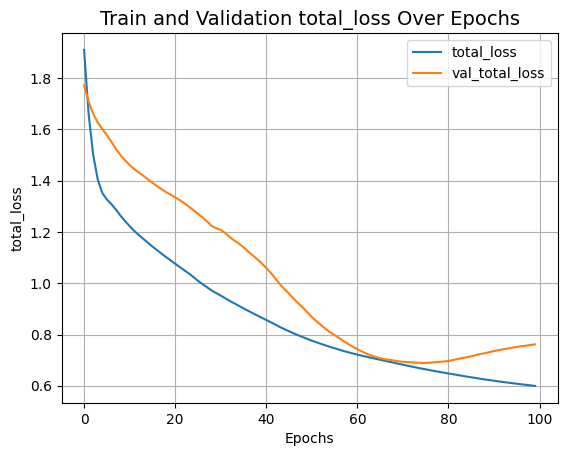

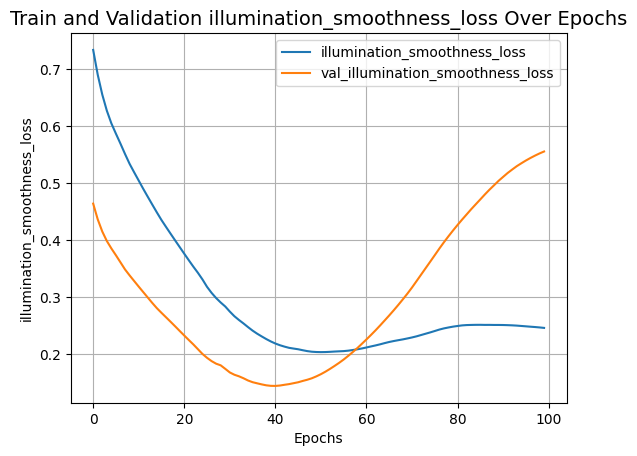

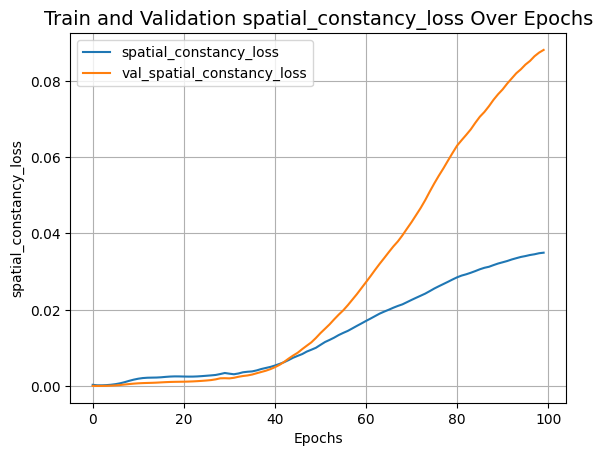

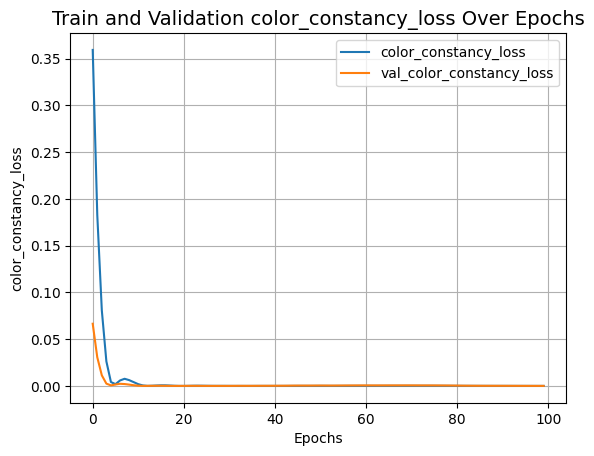

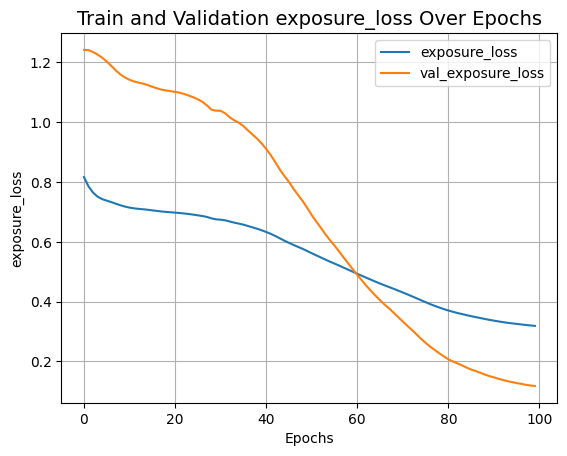

In [10]:
# Initialize and compile the model
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)

# Train the model on LOL77 datasets
history = zero_dce_model.fit(
    train_dataset,         # Your LOL77 training dataset
    validation_data=val_dataset,  # Your LOL77 validation dataset
    epochs=100
)

import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# Plot all the tracked losses
plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")


In [11]:
class ZeroDCE:
    def __init__(self):
        self.dce_model = build_model()  # however you define it

    def compile(self, learning_rate=1e-4):
        self.dce_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate),
            loss=compute_total_loss,  # assuming your loss function is named like this
            metrics=[
                illumination_smoothness_loss,
                spatial_constancy_loss,
                color_constancy_loss,
                exposure_loss,
            ]
        )

    def fit(self, *args, **kwargs):
        return self.dce_model.fit(*args, **kwargs)

    def save_weights(self, filepath):
        self.dce_model.save_weights(filepath)  # ✅ REMOVE save_format

    def load_weights(self, filepath):
        self.dce_model.load_weights(filepath)


In [12]:
# Save weights only (corrected earlier)
zero_dce_model.dce_model.save_weights("/content/dce_model.weights.h5")

# Save full model in new Keras format
zero_dce_model.dce_model.save("/content/dce_model.keras")


In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.expand_dims(image, axis=0)

def display_enhanced(image_path, model):
    image = load_image(image_path)
    enhanced = model(image, training=False)[0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(tf.squeeze(image))
    axes[0].set_title("Original (Low Light)")
    axes[0].axis("off")

    axes[1].imshow(tf.clip_by_value(enhanced, 0, 1))
    axes[1].set_title("Enhanced")
    axes[1].axis("off")

    plt.show()


In [14]:
import os
print(os.path.exists("/content/LOL_dataset/low/0001.png"))


True


In [19]:
def display_enhanced(image_path, model):
    image = load_image(image_path)
    enhanced = model(image, training=False)  # get model output

    print("Enhanced shape:", enhanced.shape)  # DEBUG: print shape to check

    if len(enhanced.shape) == 4 and enhanced.shape[-1] == 24:
        enhanced = tf.reshape(enhanced, (1, 256, 256, 8, 3))
        enhanced = enhanced[:, :, :, -1, :]

    image = tf.squeeze(image)
    enhanced = tf.squeeze(enhanced)

    print("Sample pixel value from enhanced image:", enhanced[128,128])  # DEBUG

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original (Resized)")
    axes[0].axis("off")

    axes[1].imshow(tf.clip_by_value(enhanced, 0, 1))
    axes[1].set_title("Enhanced Output")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


Enhanced shape: (1, 256, 256, 24)
Sample pixel value from enhanced image: tf.Tensor([-0.03219134 -0.05712922 -0.06637506], shape=(3,), dtype=float32)


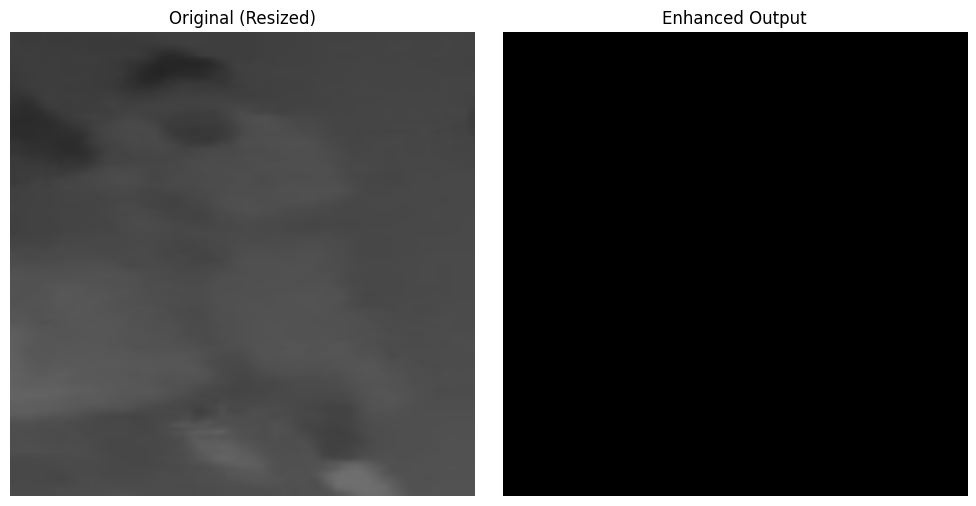

In [20]:
display_enhanced("/content/LOL_dataset/low/0001.png", zero_dce_model.dce_model)


In [22]:
def display_enhanced(image_path, model):
    image = load_image(image_path)
    enhanced = model(image, training=False)

    print("Enhanced shape:", enhanced.shape)

    if len(enhanced.shape) == 4 and enhanced.shape[-1] == 24:
        enhanced = tf.reshape(enhanced, (1, 256, 256, 8, 3))
        enhanced = enhanced[:, :, :, -1, :]

    image = tf.squeeze(image)
    enhanced = tf.squeeze(enhanced)

    min_val = tf.reduce_min(enhanced)
    max_val = tf.reduce_max(enhanced)
    print(f"Enhanced min: {min_val.numpy()}, max: {max_val.numpy()}")

    enhanced_norm = (enhanced - min_val) / (max_val - min_val + 1e-8)

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original (Resized)")
    axes[0].axis("off")

    axes[1].imshow(enhanced_norm)
    axes[1].set_title("Enhanced Output (Normalized)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


Enhanced shape: (1, 256, 256, 24)
Enhanced min: -0.16168108582496643, max: -0.020155368372797966


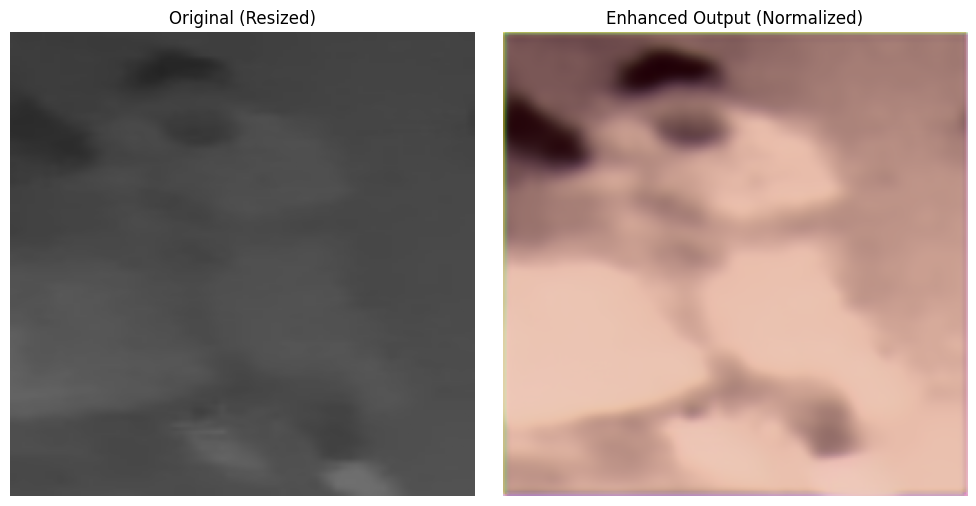

In [23]:
display_enhanced("/content/LOL_dataset/low/0001.png", zero_dce_model.dce_model)
